In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
import torch.nn.functional as F
import numpy as np
import random
from sklearn import preprocessing

import os
from pprint import pprint
from csv import reader
import csv, os, argparse, sys

from sklearn.cluster import KMeans

import pandas as pd
import matplotlib.pyplot as plt

import scanpy as sc

from glmpca import glmpca

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import sys
sys.path.append('/n/fs/ragr-research/projects/GASTON-Mix/src/gastonmix/')
import dim_reduction
from run_moe_script import *

# Step 1: Load data and run dimensionality reduction

GASTON requires:

* N x G counts matrix
* N x 2 spatial coordinate matrix,
* list of names for each gene

where N=number of spatial locations and G=number of genes.

There are two options for pre-processing: (1) using GLM-PCA or (2) using top PCs of Pearson residuals.

For this dataset, we previously extracted the ``striatum" region from a much larger MERFISH adata object

In [2]:
folder='striatum_1058/'
counts_mat=np.load(folder+'counts_mat.npy')
coords_mat=np.load(folder+'coords_mat.npy')
gene_labels=np.load(folder+'gene_names.npy',allow_pickle=True)

## Option 1: GLMPCA

In [ ]:
# GLM-PCA parameters
num_dims=20
penalty=10 # may need to increase if this is too small

# CHANGE THESE PARAMETERS TO REDUCE RUNTIME
num_iters=30
eps=1e-4
num_genes=30000 # smaller value means using fewer genes

##################################################################

counts_mat_glmpca=counts_mat[:,np.argsort(np.sum(counts_mat, axis=0))[-num_genes:]]
glmpca_res=glmpca.glmpca(counts_mat_glmpca.T, num_dims, fam="poi", penalty=penalty, verbose=True,
                        ctl = {"maxIter":num_iters, "eps":eps, "optimizeTheta":True})
A = glmpca_res['factors'] # should be of size N x num_dims, where each column is a PC

np.save('striatum_1058/glmpca_mat.npy', A)

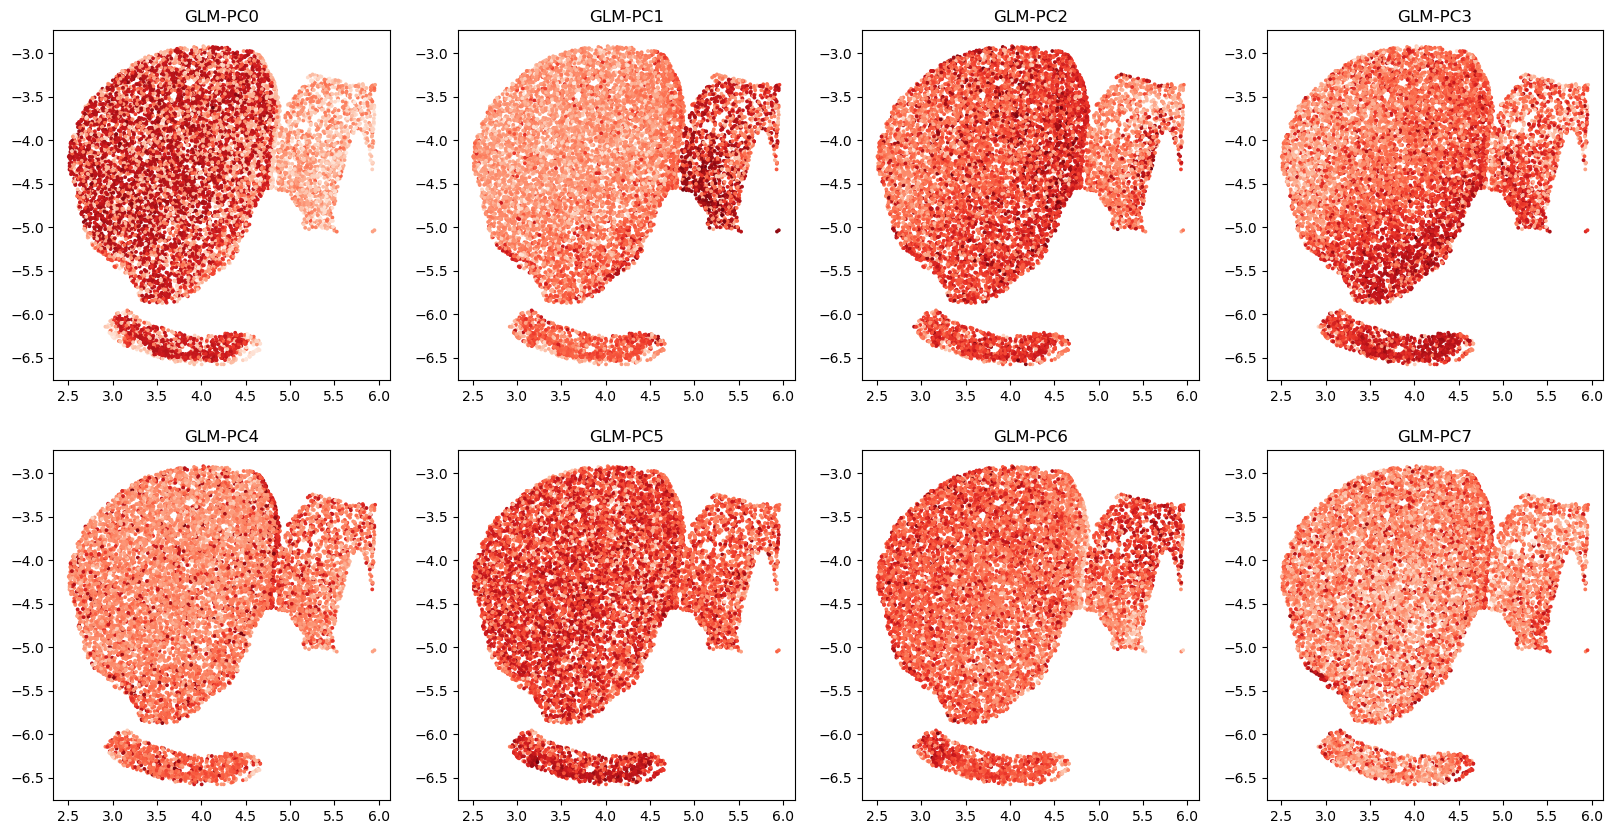

In [3]:
# visualize top GLM-PCs
# here we use pre-computed GLM-PCs
# A=np.load('striatum_1058/glmpca_mat.npy')

R=2
C=4
fig,axs=plt.subplots(R,C,figsize=(20,10))
for r in range(R):
    for c in range(C):
        i=r*C+c
        axs[r,c].scatter(coords_mat[:,0], coords_mat[:,1], c=A[:,i],cmap='Reds',s=3)
        axs[r,c].set_title(f'GLM-PC{i}')

## Option 2: top PCs of analytic Pearson residuals

Faster, but lower quality

In [4]:
num_dims=8 # 2 * number of clusters
clip=0.01 # have to clip values to be very small!

A = dim_reduction.get_top_pearson_residuals(num_dims,counts_mat,coords_mat,gene_labels,clip=clip)

/n/fs/ragr-data/users/uchitra/miniconda3/envs/gaston-mix/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/n/fs/ragr-research/projects/GASTON-Mix/src/gastonmix/dim_reduction.py:15: ImplicitModificationWarning: Setting element `.layers['raw']` of view, initializing view as actual.
  adata.layers["raw"] = adata.X.copy()


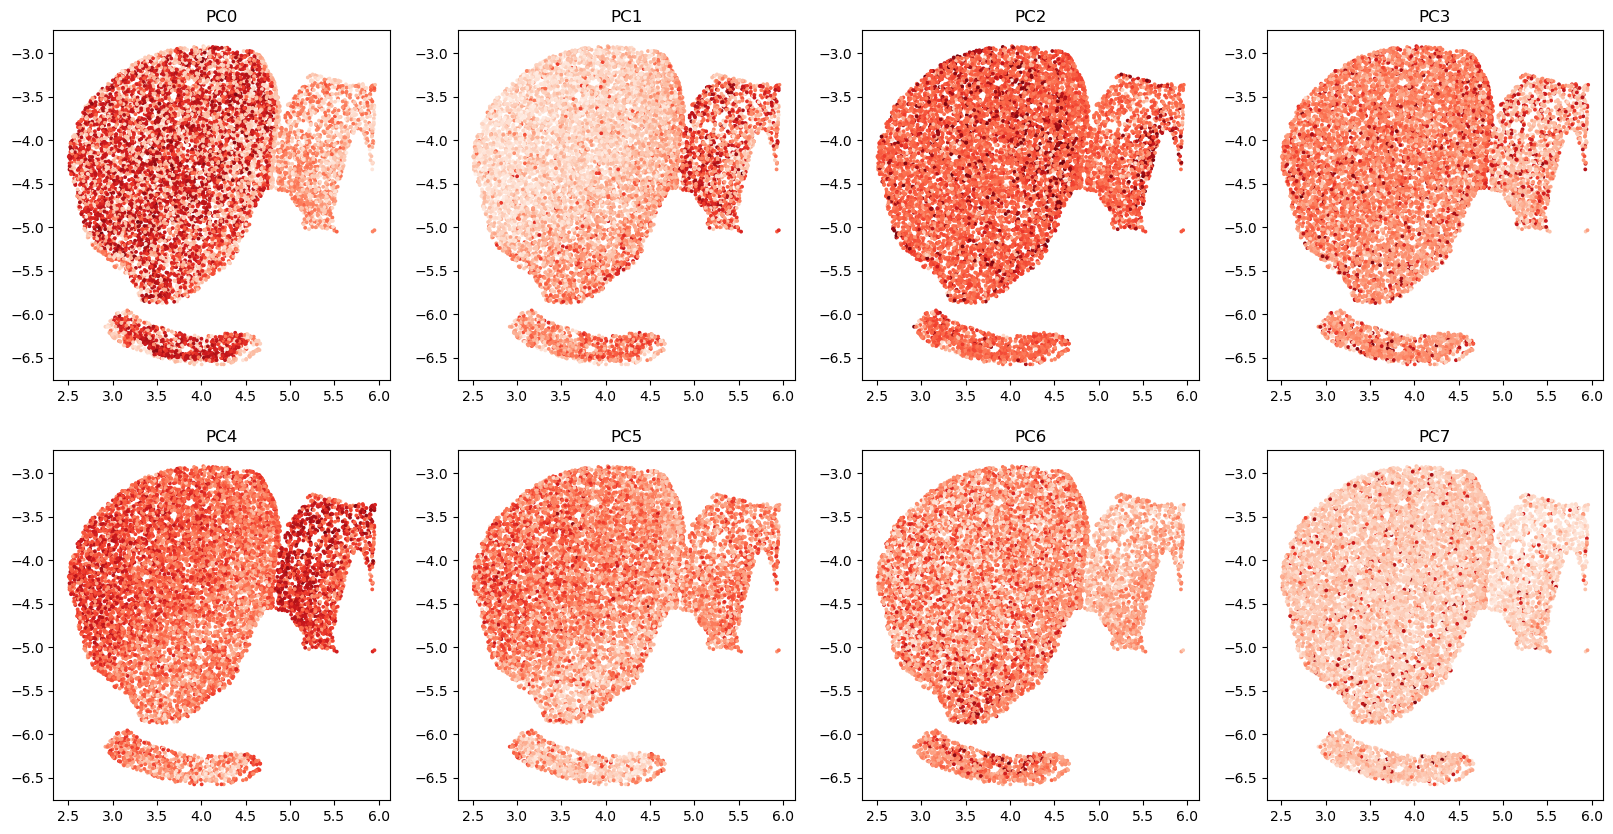

In [5]:
# visualize top GLM-PCs
R=2
C=4
fig,axs=plt.subplots(R,C,figsize=(20,10))
for r in range(R):
    for c in range(C):
        i=r*C+c
        axs[r,c].scatter(coords_mat[:,0], coords_mat[:,1], c=A[:,i],cmap='Reds',s=3)
        axs[r,c].set_title(f'PC{i}')

# Step 1.5 (optional): get cluster labels to initialize network

## Option 1: CellCharter 

Run CellCharter (Varrone et al, Nat Genet 2024). Unfortunately there are some dependency conflicts right now with squidpy so we currently do not have the CellCharter code here. You can follow their tutorial https://cellcharter.readthedocs.io/en/latest/notebooks/cosmx_human_nsclc.html

We plot their clusters below

(np.float64(2.3320459284342805),
 np.float64(6.131641157738978),
 np.float64(-6.757893954014918),
 np.float64(-2.73397252724503))

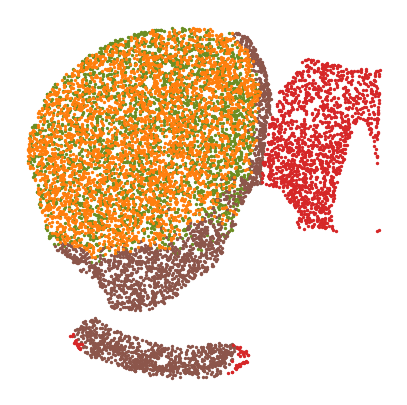

In [8]:
cc_labels=np.load('striatum_1058/cellcharter_labels_4.npy')

fig,ax=plt.subplots(figsize=(5,5))
colors=['olivedrab', 'C5', 'C3', 'C1']
for t in np.unique(cc_labels):
    plt.scatter(coords_mat[cc_labels==t,0],coords_mat[cc_labels==t,1],s=2,label=t,c=colors[t])

plt.axis('off')

## Option 2: k-means on GLM-PCs

(np.float64(2.3320459284342805),
 np.float64(6.131641157738978),
 np.float64(-6.757893954014918),
 np.float64(-2.73397252724503))

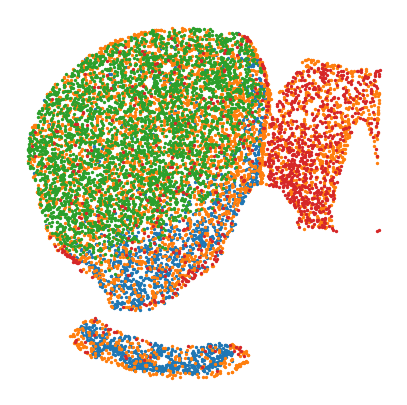

In [12]:
n_clusters=4 # CHANGE to number of experts
A=np.load('striatum_1058/glmpca_mat.npy')

kmeans=KMeans(n_clusters=4)
kmeans.fit(A)
kmeans_labels=kmeans.labels_
fig,ax=plt.subplots(figsize=(5,5))
for t in np.unique(kmeans_labels):
    plt.scatter(coords_mat[kmeans_labels==t,0],coords_mat[kmeans_labels==t,1],s=2)
plt.axis('off')

# Step 2: Train MoE model

We train the model by running a separate script.

In [15]:
# ARGUMENTS FOR MODEL

# random seed, device
seed = 1
device='cuda'

# folders and files
dataset = "striatum_1058" # folder containing data files
folder = "striatum_1058_MoE_output" # folder to save output
coords_file="striatum_1058/coords_mat.npy" # file containing coords for NN
expression_file="striatum_1058/glmpca_mat.npy" # file containing output (eg GLM-PCs) for NN
manual_init = "striatum_1058/cellcharter_labels_4.npy" # file containing initialization for gating network (optional)


# Model params
num_epochs = 50000 #number of epochs to train MoE model for
checkpoint = 1000 # number of epochs to alternate between gating vs other networks
gating_arch = "20 20" # gating network architecture: here two hidden layers of size 20
pos_encoding_gating = "8 0.01" # positional encoding parameters for gating (positional encoding of length 8 with frequency 0.01)
spatial_arch = "20" # isodepth network architecture: one hidden layer of size 20
expression_arch = "" # 1-D expression function architecture: linear

# Set to True if you want to plot NN every checkpoint epochs
plot_intermediates = True

################################################################################################################

# Construct the command dynamically
if plot_intermediates:
    plot_interm="--plot_interm"
else:
    plot_interm=""
cmd = f"python src/gastonmix/run_moe_script.py -s {seed} -d {dataset} -f {folder} --manual_init {manual_init} --coords_file {coords_file} "
cmd += f"--expression_file {expression_file} --num_epochs {num_epochs} --checkpoint {checkpoint} --gating_arch {gating_arch} "
cmd += f"--spatial_arch {spatial_arch} --expression_arch {expression_arch} {plot_interm} --pos_encoding_gating {pos_encoding_gating} --device {device}"

# Run the command
import os
os.system(cmd)

device: cuda
num_experts not specified, loading from manual init
Manual initialization
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
self.enc_dim_g: 8, self.sigma_g: 0.01, self.include_orig_coords: False
self.enc_dim_i: None, self.sigma_i: None, self.include_orig_coords: False
epoch: 0
regularization loss: 0
total loss: 1.2754422426223755
epoch: 1000
regularization loss: 0
total loss: 0.9217402935028076
epoch: 2000
regularization loss: 0
total loss: 0.8945264220237732
epoch: 3000
regularization loss: 0
total loss: 0.8876634240150452
epoch: 4000
regularization loss: 0
total loss: 0.8857436776161194
epoch: 5000
regularization loss: 0
total loss: 0.8861120343208313
epoch: 6000
regularization loss: 0
total loss: 0.8849719762802124
epoch: 7000
regularization loss: 0
total loss: 0.8858664035797119
epoch: 8000
regularization 

0

# Step 3: Visualize output

## Plot all isodepths

The isodepth values are not yet scaled, so they can take on arbitrary ranges

/n/fs/ragr-research/projects/GASTON-Mix/src/gastonmix/plot_isodepths.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  moe_model=torch.load(output_folder + f'seed{seed}/'

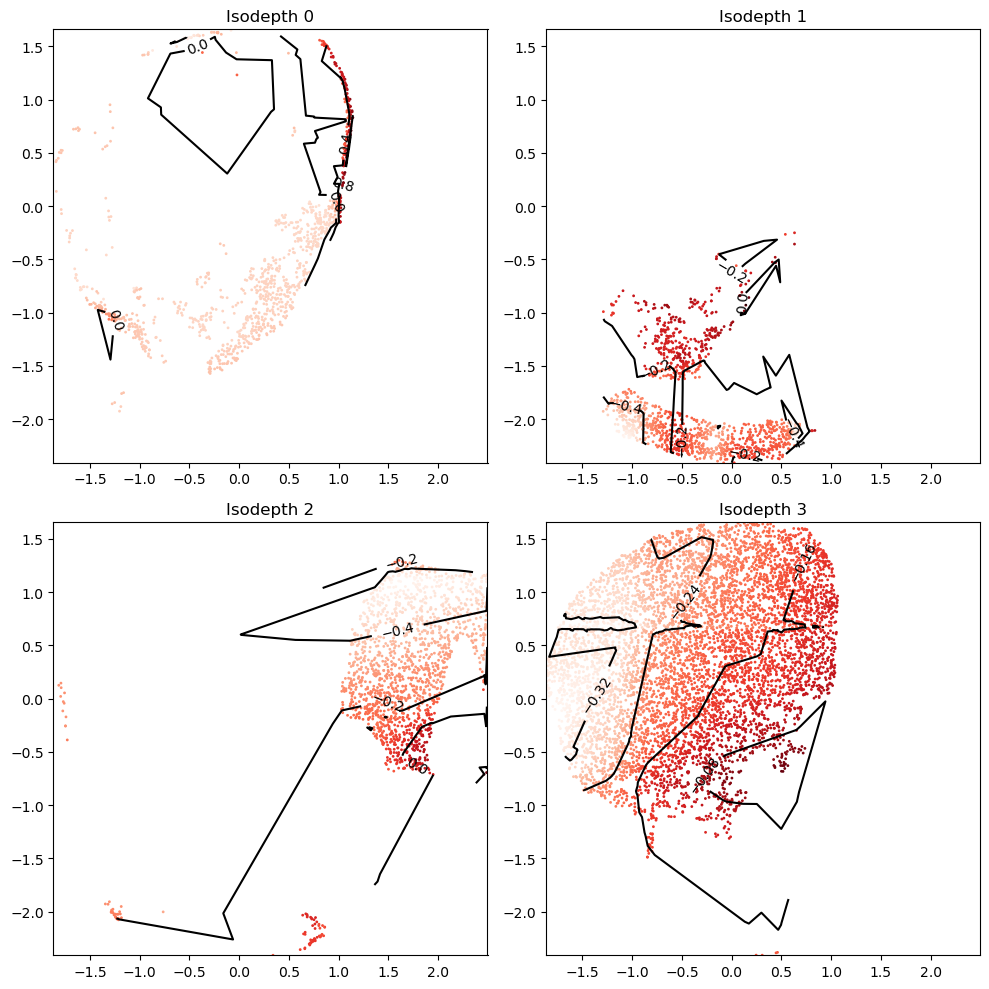

In [70]:
import plot_isodepths

# MODEL TO LOAD
seed=1
output_folder='striatum_1058_MoE_output/'
model='final_model.pt' # can replace with intermediate model if desired, eg model_epoch_10000.pt

# PLOTTING PARAMETERS
levels=3 # number of contours

gastonmix_labels,_=plot_isodepths.plot_all_isodepths(output_folder,seed,model=model,outlier_threshold=10,levels=levels)

## Plot topographic map of specific isodepth/expert

/n/fs/ragr-research/projects/GASTON-Mix/src/gastonmix/plot_isodepths.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Atorch=torch.load(output_folder + f'seed{seed}/' + 

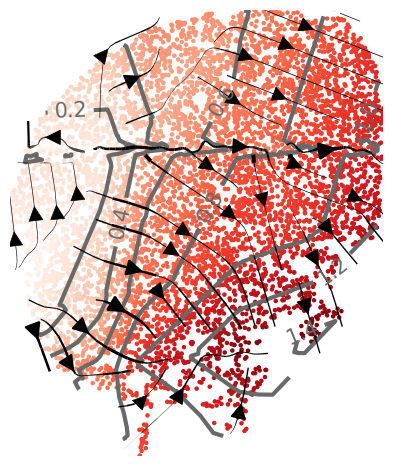

In [71]:
reload(plot_isodepths)
# which isodepth/expert to plot
expert_ind=3

# PLOTTING PARAMETERS
outlier_threshold=3 # sometimes experts contain far-away points; we omit displaying all points within outlier_threshold of the mean
levels=7 # number of contours
linewidth=2.5 # width of contours
density=0.6 # density of gradient arrows
arrowsize=2.5 # size of arrows
figsize=(4.5,5) # length, width of figure

isodepth=plot_isodepths.plot_individual_isodepth(expert_ind,output_folder,seed,model='final_model.pt',
                                        outlier_threshold=outlier_threshold,levels=levels,
                            linewidth=linewidth,density=density,arrowsize=arrowsize,figsize=figsize)

## Plot cell type vs isodepth

Needed: a dataframe of size N x C, where rows are spatial locations and columns are cell types

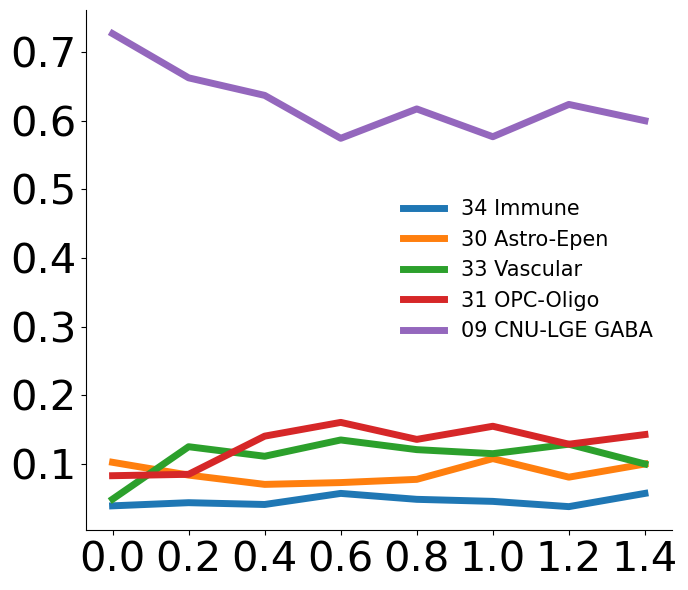

In [157]:
import plot_cell_types

cell_type_df=pd.read_csv('striatum_1058/cell_type_df.csv',index_col=0)

# PLOTTING PARAMETERS
num_bins=15
num_cts=5 # number of cell types to show
figsize=(7,6) # length x width of figure

plot_cell_types.plot_ct_vs_isodepth(cell_type_df,expert_ind,gastonmix_labels,isodepth,num_bins=num_bins,num_cts=num_cts,
                       figsize=figsize)

## Gene expression vs isodepth

Do Poisson regression for all genes (with large enough UMIs)

In [ ]:
import gene_fitting
reload(gene_fitting)


# PARAMETERS FOR FITTING INDIVIDUAL GENES
 
# cell_type_df=None # use None if you do not need cell type-specific analysis

num_cts=5 # number of cell types to compute cell type-specific fits
t=0.1 # set slope=0 if LLR p-value > 0.1
q=0.2 # only fit genes whose UMI count is in top q percentile; alternatively can set umi_threshold directly
num_bins=7 # number of bins when plotting

pw_fit_dict, binning_output,ct_list=gene_fitting.perform_regressions_and_binning(counts_mat, expert_ind,gastonmix_labels, isodepth, gene_labels,
                                    cell_type_df=cell_type_df,num_cts=num_cts,t=t,q=q,num_bins=7)

Get genes with large slopes

In [159]:
q=0.95

# gradient genes over all spots
cont_genes_layer=gene_fitting.get_cont_genes(pw_fit_dict, binning_output,q=q)

# cell type-specific gradient genes
# cont_genes_layer_ct=gene_fitting.get_cont_genes(pw_fit_dict, binning_output,q=q,ct_attributable=True,domain_cts={0:ct_list})

In [160]:
cont_genes_layer

defaultdict(list,
            {'Rxrg': [0],
             'Ramp3': [0],
             'Gpr101': [0],
             'Tcerg1l': [0],
             'Myo3b': [0],
             'Igfbp4': [0],
             'Stxbp6': [0],
             'Kctd8': [0],
             'Dchs2': [0],
             'Gpr26': [0],
             'Gpr139': [0],
             'Crym': [0],
             'Dlk1': [0],
             'Itga9': [0],
             'Atp6v1c2': [0],
             'Cckbr': [0],
             'Lypd6b': [0],
             'Cbln4': [0],
             'St6galnac5': [0],
             'Adam12': [0],
             'Npy2r': [0],
             'Meox2': [0],
             'Col6a1': [0],
             'Cpne9': [0],
             'P2ry1': [0],
             'Pde1a': [0],
             'Pde11a': [0],
             'Sfrp1': [0],
             'Pkp2': [0],
             'Adamts16': [0],
             'Fzd5': [0],
             'Pdyn': [0],
             'Man1a': [0],
             'Rprm': [0],
             'Baiap3': [0],
             'Calb1': 

In [161]:
cont_genes_layer_ct

{'Rxrg': [(0, '34 Immune'),
  (0, '30 Astro-Epen'),
  (0, '33 Vascular'),
  (0, '31 OPC-Oligo'),
  (0, '09 CNU-LGE GABA')],
 'Ramp3': [(0, '34 Immune'),
  (0, '33 Vascular'),
  (0, '31 OPC-Oligo'),
  (0, '09 CNU-LGE GABA')],
 'Gpr101': [(0, '30 Astro-Epen'), (0, '09 CNU-LGE GABA')],
 'Tcerg1l': [(0, '34 Immune'), (0, '31 OPC-Oligo'), (0, '09 CNU-LGE GABA')],
 'Myo3b': [(0, '31 OPC-Oligo'), (0, '09 CNU-LGE GABA')],
 'Igfbp4': [(0, '30 Astro-Epen'), (0, '31 OPC-Oligo'), (0, '09 CNU-LGE GABA')],
 'Stxbp6': [(0, '30 Astro-Epen'), (0, '09 CNU-LGE GABA')],
 'Kctd8': [(0, '34 Immune'), (0, '31 OPC-Oligo'), (0, '09 CNU-LGE GABA')],
 'Dchs2': [(0, '09 CNU-LGE GABA')],
 'Gpr26': [(0, '30 Astro-Epen'), (0, '33 Vascular'), (0, '09 CNU-LGE GABA')],
 'Gpr139': [(0, '30 Astro-Epen'), (0, '31 OPC-Oligo'), (0, '09 CNU-LGE GABA')],
 'Crym': [(0, '34 Immune'),
  (0, '30 Astro-Epen'),
  (0, '33 Vascular'),
  (0, '31 OPC-Oligo'),
  (0, '09 CNU-LGE GABA')],
 'Dlk1': [(0, '34 Immune'),
  (0, '33 Vascular'),


### Plot  individual gene

Plot isodepth vs expression

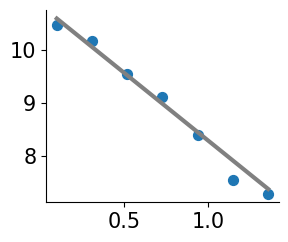

In [162]:
import plot_genes
reload(plot_genes)

gene_name='Cnr1'
offset=10**6 # for logCPM; use smaller number for eg CP10K

plot_genes.plot_gene_pwlinear(gene_name, pw_fit_dict, expert_ind, gastonmix_labels, isodepth, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=['C0'], 
                                        linear_fit=True, ticksize=15, figsize=(3,2.5), offset=offset, lw=3,
                                       domain_boundary_plotting=True)

Plot raw gene expression

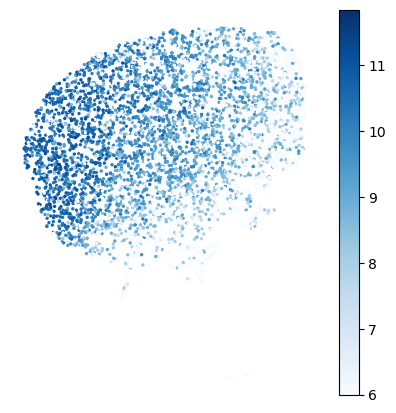

In [163]:
gene_name='Cnr1'
offset=10**6 # for logCPM; use smaller number for eg CP10K

# set min/max of colorbar
vmin=6
vmax=None

# plotting
cmap='Blues' # matplotlib colormap
figsize=(5,5)

plot_genes.plot_gene_raw(gene_name, gene_labels, counts_mat[gastonmix_labels==expert_ind,:], 
                                   coords_mat[gastonmix_labels==expert_ind,:], 
                                   offset=offset, figsize=figsize, colorbar=True, vmax=vmax, vmin=vmin, 
                                   s=2, rotate=None,cmap=cmap)




Plot GASTON 2D expression function

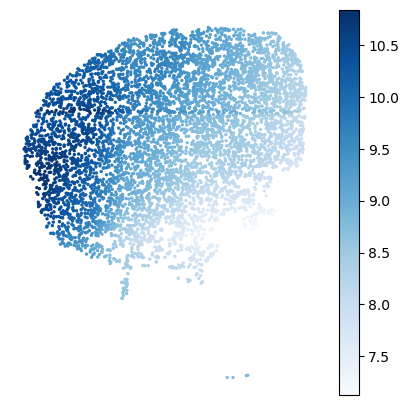

In [164]:
gene_name='Cnr1'
offset=10**6 # for logCPM; use smaller number for eg CP10K

# plotting parameters
cmap='Blues' # matplotlib colormap
figsize=(5,5)

plot_genes.plot_gene_function(gene_name, coords_mat[gastonmix_labels==expert_ind,:], pw_fit_dict, 
                                        np.zeros(np.sum(gastonmix_labels==expert_ind)), 
                                        isodepth, binning_output, figsize=figsize,s=2,cmap=cmap)

Plot cell type-specific expression functions

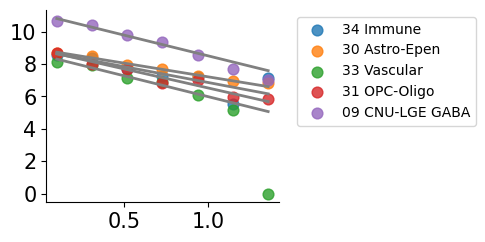

In [165]:
gene_name='Cnr1'
offset=10**6 # for logCPM; use smaller number for eg CP10K

# plotting
figsize=(3,2.5)
ct_colors=None # replace with list of colors for plotting each cell type

plot_genes.plot_gene_pwlinear(gene_name, pw_fit_dict, expert_ind, gastonmix_labels, isodepth, binning_output,
                                        cell_type_list=ct_list,ct_colors=ct_colors, spot_threshold=0.01, pt_size=60, 
                                        colors=None, linear_fit=True, domain_list=[0],ticksize=15, 
                                        figsize=figsize, offset=offset, lw=2, alpha=0.8,show_lgd=True)
